# NLP for grading ELL student essays

**Background**  
Here we attempt to create a NLP deep learning model to determine the scores for four different metrics for scoring essays. These essays are from 8th - 12th grade English Language Learners. This will help teachers by creating a high throughput grader for essays, creating a nearly instant feedback model for students. Having nearly immediate feedback will help students correct mistakes while their writing is fresh in their mind. Receiving grades days or weeks later may have little impact on their future writing. Creating a machine learning model for teachers will also decrease their time spent on grading, freeing up their life and time during school to assist students in other ways.

**Summary**  
(Draft) Using a deep learning model we were able to predict accuracy for [metrics] up to [x]%. 

**Kaggle Competition**  
Feedback Prize - English Language Learning - Evaluating language knowledge of ELL students from grades 8-12 

**Source**  
https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/evaluation

**API Call**  
kaggle competitions download -c feedback-prize-english-language-learning

**Goal**  
- Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. The scores range from 1.0 to 5.0 in increments of 0.5. Your task is to predict the score of each of the six measures for the essays given in the test set.

  Additional competition and datset: Feedback Prize - Predicting Effective Arguments https://www.kaggle.com/competitions/feedback-prize-effectiveness/data

# Setup

## Load Packages

In [1]:
!pip install tensorflow keras nltk tensorflow_text sklearn shap &>/dev/null
!echo "Packages installed"

Packages installed


In [4]:
# standard
import os
import random
import warnings
from collections import Counter
import re
from datetime import date

import pandas as pd
import numpy as np
import pickle

# Google colab for data storage
from google.colab import drive
from google.colab import files

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords 
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.corpus import words

# Tensorflow and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout

import tensorflow_text as tf_text
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from wordcloud import WordCloud


## Notebook options

In [6]:
# Mount google drive
drive.mount('/content/drive')

# Paths
main_path = "/content/drive/MyDrive/"

project_path = "W207_final_project/"
data_path = "data/"
save_path = "".join([date.today().strftime('%Y%m%d'), "_eda_models/"])

project_path = "".join([main_path, project_path])
data_path = "".join([project_path, data_path])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("data path: ", data_path)
print("save path: ", save_path)


# Pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2)
%matplotlib inline

# Graphing options
sns_old_theme = sns.set_theme()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
project path:  /content/drive/MyDrive/W207_final_project/
data path:  /content/drive/MyDrive/W207_final_project/data/
save path:  /content/drive/MyDrive/W207_final_project/20221207_eda_models/


In [7]:
# Download stop words
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')

stop_words= set(stopwords.words('english'))


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Graphing Options

In [15]:
sns_theme_original = sns.set_theme()

# custom_params = {
#     "axes.spines.right": False,
#     "axes.spines.top":False
#     }

# sns.set_theme(
#     context = "talk", 
#     style = "white", 
#     rc = custom_params
# )

## Functions

In [16]:
def connect_git(connect = False, commit = False, push = False):
  """
  To be used when connecting to github for version control. 

  Creates connection to github to allow users to commit and push data into repository listed below. 
  Requires that users load their own github token, which they will be prompted to do so.

  Parameters:
    connect (bool): True to set up the connection to github
    commit (bool): Commit changes and files
    push (bool): Push commited changes 

  Returns:
    None

  """

  if connect == True:
    %cd "/content/drive/MyDrive/W207_final_project"
    !git config --global user.email "nick.lee@berkely.edu"
    !git init 
    # upload git token:
    files.upload()

    username = "leen01"
    with open("./git_token.txt", 'r') as file:
      git_token = file.read()
    repository = "w207_final_project"

    !git remote set-url origin https://{git_token}@github.com/{username}/{repository}

    %cd "./w207_final_project/"

    !git pull origin main
    !git status

    # !git clone https://{git_token}@github.com/{username}/{repository}

    if commit == True: 
      !git add Final_project_NLP_NL_v0.3.ipynb
      !git status
      !git commit -m "20221125 upload"
    
    if push == True: 
      !git push -u origin main
    
    #git cleanup 
    !rm ../git_token.txt


### Preprocessing functions

In [23]:
def load_fresh_dataset(): 
  """
  Load in original dataset. 

  Parameters:
    None

  Returns:
    train (dataframe): train set for training models
    test (dataframe): test for evaluating the models

  """
  
  train = pd.read_csv(os.path.join(data_path, "train.csv"))
  test = pd.read_csv(os.path.join(data_path,"test.csv"))

  print("Train shape: ", train.shape)
  print(train.info())
  print("Test shape: ", test.shape)

  return train, test

def preprocessor(text):
  """
  Removing puncuation and emoticons from dataset

  Parameters:
    text (string): Text to be processed to prepare for NLP modeling

  Returns:
    string: transformed string without puncuation and emoticons

  """

  # remove puncuations
  text = re.sub('<[^>]*>', '', text)
  
  # Removing emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                          text)
  
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', ''))
  
  return text

def preprocessor_v2(text): 
  
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('[‘’“”…]', '', text)
  text = re.sub('\n', '', text)

  return text

def sentence_spliter(text): 
  """
  Splitting text into sentences to be tokenized into sequences

  If pursuing a way to look at sentences that make up an essay, this could be a helpful function. 
  Not intended to be used after the preprocessing function.
  *May take out later if not used. 

  Parameters:
    text (string): Text to be split

  Returns:
    list: list of lists containing a single sentence

  """

  # If periods are used for other purposes
  text = [t.strip() for t in text.split(".")]
  return text


def stopword_removal(text): 
  """
  Remove stop words from text to prepare data for NLP modeling.

  Taking the stop words set above from the nltk model to remove these words form the text. 
  Removing these words should not harm the models since they are often repeated and add little meaning to the scoring. 
  As a baseline, a model will be built without the stop words removed. 
  This may help since the students are ELL and may be working on common stop words in their writing. 

  Parameters:
    text (string): Text to be transformed

  Returns:
    pandas series: series that contains the transformed text and stopword count (int)

  """

  stopword_count = 0

  words = word_tokenize(text)
  wordsFiltered = []

  for w in words:
      if w not in stop_words:
          wordsFiltered.append(w)
      else: 
        stopword_count += 1

  text = " ".join(wordsFiltered)

  return pd.Series([text, stopword_count])

# define function for token encoder
def encode(text_tensor, label):
  """
  Summary line.

  Extended description of function.

  Parameters:
    arg1 (int): Description of arg1

  Returns:
    int: Description of return value

  """

  text = text_tensor.numpy()[0]

  encoded_text = encoder.encode(text)
  
  return encoded_text, label


#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
  """
  Summary line.

  Extended description of function.

  Parameters:
    arg1 (int): Description of arg1

  Returns:
    int: Description of return value

  """

  return tf.py_function(encode, inp=[text, label], 
                        Tout=(tf.float64, tf.float64))


def pad_data(sequences, max_length):
  """
  Summary line.

  Extended description of function.

  Parameters:
    arg1 (int): Description of arg1

  Returns:
    int: Description of return value

  """

  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

### Graphing functions

In [195]:
def word_cloud_plot(text):
  """
  Creating a word cloud of the text to better understand what are the most frequent words in a given text.

  By understandind the most commonly used words across the different texts we can see if there are any additional words to be removed. 
  Removing additional words may help us to differentiate scores across the imbalanced training set. 

  Parameters:
    text (string): Text to be transformed

  Returns:
    plot: word cloud plot 

  """
  wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
  
  wc.generate(text)

  plt.figure(figsize=(20, 6))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")

  return wc

def plot_history(history):
  """ 
  For plotting the histories from models
  
  Prints matplot lib graphs of the accuracy and loss over epochs used during training

  Parameters: 
    history: object from model.fit(...)

  Returns: 
    None

  """
  
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)

  ax = fig.add_subplot(1, 2, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=15)
  ax.set_ylim(0,1)
  plt.show()

def confusion_matrix_plot(conf_matrix):
  """
  Confusion matrix matplotlib plot
  # param conf_matrix: nested list of TP, TN, FP, FN
  # return: None
  Summary line.

  Extended description of function.

  Parameters:
    arg1 (int): Description of arg1

  Returns:
    int: Description of return value

  """

  fig, ax = plt.subplots(figsize=(2.5, 2.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.tight_layout()
  plt.show()


def plot_value_array(i, predictions_array, true_label):
  """
  Summary line.

  Extended description of function.

  Parameters:
    arg1 (int): Description of arg1

  Returns:
    int: Description of return value

  """

  true_label = true_label[i]

  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  plt.title('ground truth: ' + str(true_label))

  thisplot = plt.bar(range(3), predictions_array, color="#777777")

  plt.ylim([0, 1])
  
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [19]:
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
  """
  Define and use a simple function to label the plot in axes coordinates

  Extended description of function.

  Parameters:
  x (int): Description of arg1
  color (): 
  label (): 

  Returns:
  int: Description of return value

  """
  ax = plt.gca()
  ax.text(0, .2, label, fontweight="bold", color=color,
          ha="left", va="center", transform=ax.transAxes)
  
def ridge_plot(df, col, val): 
  """
  To create the ridge plots of multiple metrics that have been placed in a long formated table. 

  Extended description of function.

  Parameters:
  df (dataframe):
  col (string): 
  val (float): 

  Returns:
  seaborn plot: Description of return value

  """
  sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

  pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

  g = sns.FacetGrid(df, row = col, hue = col, aspect=5, height =0.5, palette = pal, sharey=False)

  # Draw densities
  g.map(sns.kdeplot, val, bw_adjust = 0.5, clip_on = False, fill = True, alpha = 1, linewidth = 1.5)
  g.map(sns.kdeplot, val, clip_on=False, color="w", lw=2, bw_adjust=.5)

  # passing color=None to refline() uses the hue mapping
  g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

  g.map(label, val)

  # Set the subplots to overlap
  g.figure.subplots_adjust(hspace=-.25)

  # Remove axes details that don't play well with overlap
  g.set_titles("")
  g.set(yticks=[], ylabel="")
  g.despine(bottom=True, left=True)
  g.fig.suptitle(str.capitalize(col))

  return g

### Model Functions

In [165]:
def inspect_model(model):
  """
  Summary line.

  Extended description of function.

  Parameters:
  arg1 (int): Description of arg1

  Returns:
  int: Description of return value

  """
  display(model.layers)
  display(model.summary())

  # Retrieve the embeddings layer, which itself is wrapped in a list.
  embeddings = model.layers[0].get_weights()[0]
  display("Embeddings layer - shape: ", embeddings.shape)
  display("Embeddings layer - parameter matrix (before training): ", embeddings)


def numpy_summary(ar): 
  """
  For inspecting predictions

  Extended description of function.

  Parameters:
    ar (array): 

  Returns:
    data frame: dataframe with values as rows and entries as columns

  """
  
  stats = {}
  stats['min'] = np.min(ar)
  stats['25%'] = np.quantile(ar, 0.25)
  stats['median'] = np.quantile(ar, 0.5)
  stats['75%'] = np.quantile(ar, 0.75)
  stats['max'] = np.max(ar)
  stats['mean'] = np.mean(ar)

  stats = pd.DataFrame.from_dict(stats, orient = 'index')

  return stats

def cm_heatmap(cm, metric):
  """
  Create seaborn heatmap of a confustion matrix

  Used to visualize confustion matrix of models to understand where predictions are landing. 

  Parameters:
  cm (ndarray): confustion matrix in the shape (N x N). 

  Returns:
  ax (seaborn plot): heat map of confustion matrix

  """  

  titleFontDict = {"fontsize":20}

  plt.figure(figsize=(9,9))

  ax = sns.heatmap(
      cm, 
      linewidth = 1, 
      annot = True, 
      square = True,
      fmt = "d",
      cmap=sns.cubehelix_palette(as_cmap=True)
  )

  ax.set(
      xlabel = "True", 
      ylabel = "Predictions", 
      xticklabels = scores, 
      yticklabels = scores
  )

  ax.xaxis.tick_top()

  plt.title("".join(["Confustion Matrix for ", metric, "\n"]), fontdict = titleFontDict)

  plt.show()

  return ax

Create github connection

In [21]:
connect_git(connect = False)

# EDA

In [24]:
train, test = load_fresh_dataset()

Train shape:  (3911, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB
None
Test shape:  (3, 2)


In [25]:
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


   score  cohesion  syntax  vocabulary  phraseology  grammar  conventions
0    1.0        10      11           2           10        8           15
1    1.5        27      29          14           11       20           20
2    2.0       315     410         124          350      544          402
3    2.5       790     839         528          772      855          784
4    3.0      1096    1250        1503         1153      994         1151
5    3.5       988     867        1007          929      880          908
6    4.0       534     388         577          553      447          484
7    4.5       125     100         115          108      134          122
8    5.0        26      17          41           25       29           25


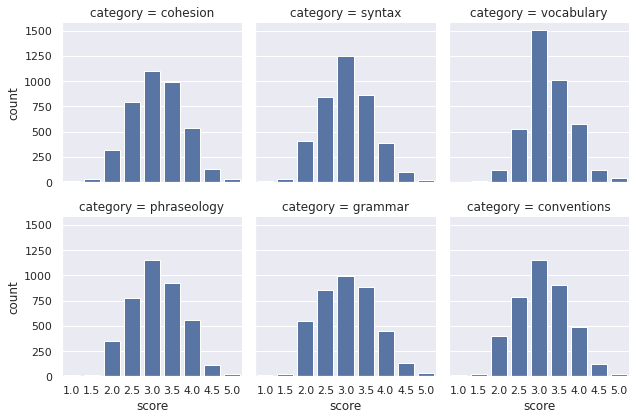

In [26]:
# Counts for ranks in each outcome variable to understand training data
outcome_vars = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

category_counts = {}

for v in outcome_vars: 
  c = Counter(train[v])
  c = dict(zip(c.keys(), c.values()))
  category_counts[v] = c

category_counts = pd.DataFrame.from_dict(category_counts).reset_index()
category_counts.rename(columns = {'index':'score'}, inplace = True)
category_counts = category_counts.sort_values(by = "score", axis = 0)

category_counts.reset_index(drop = True, inplace = True)

print(category_counts)

category_counts = pd.melt(category_counts, id_vars = "score", value_vars = outcome_vars, var_name = "category", value_name = "count")

g = sns.FacetGrid(data = category_counts, col = "category", col_wrap = 3)
g.map(sns.barplot, "score", "count")

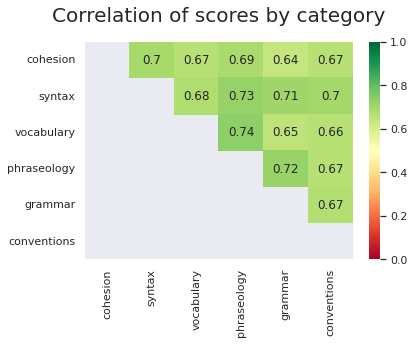

In [27]:
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, palette = "Spectral")

corr_dat = train.corr()

upper_mask = np.tril(np.ones_like(corr_dat))

dataplot = sns.heatmap(train.corr(), cmap="RdYlGn", vmin = 0, vmax = 1, annot=True, mask = upper_mask)

dataplot.set_title("Correlation of scores by category", pad = 20, fontdict = {'fontsize': 20})

plt.show()

Appears that phraseology and syntax and vocbulary are all related. I would think these are colinear with each other since they cover a similar type of characteristic. But there are no clear categories that stick out.

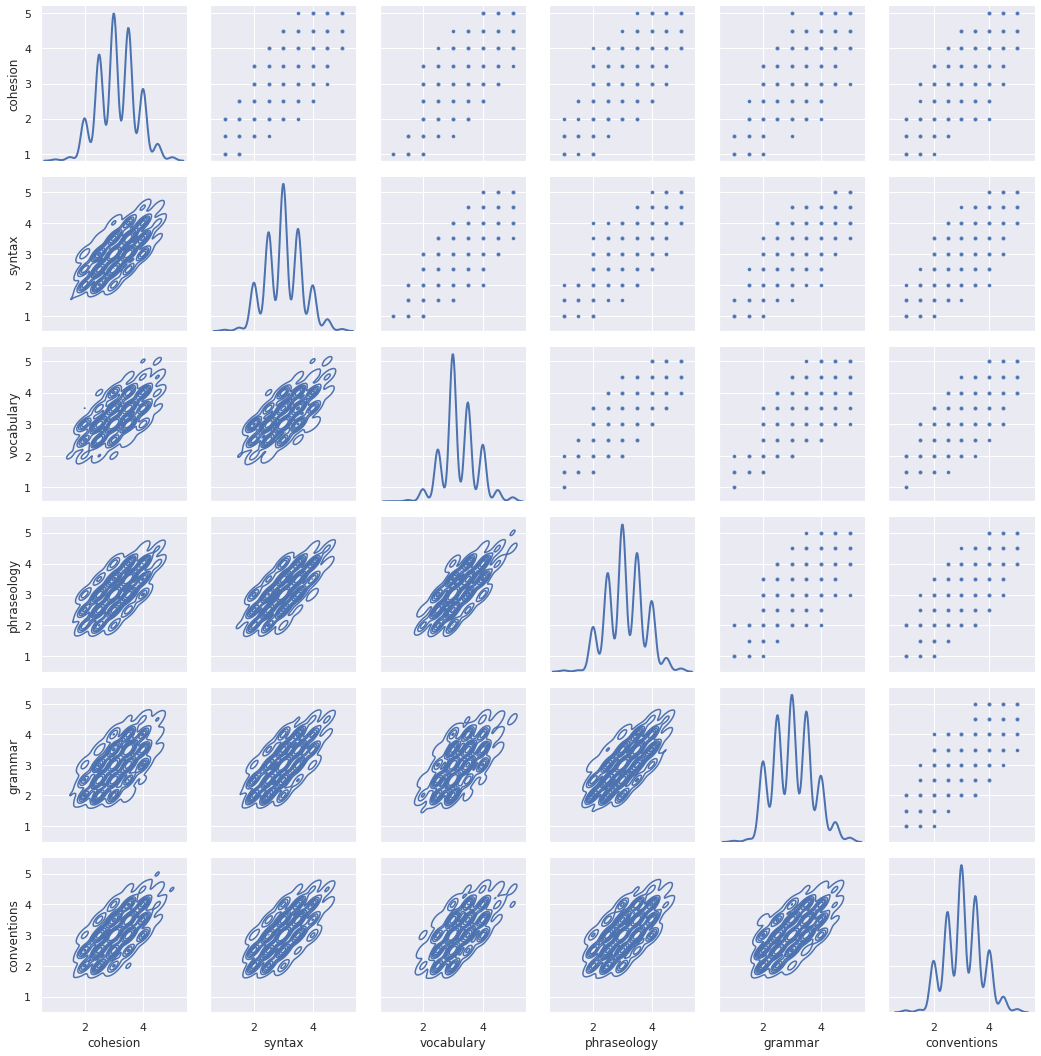

In [28]:
# Takes a long time to run

g = sns.PairGrid(train, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

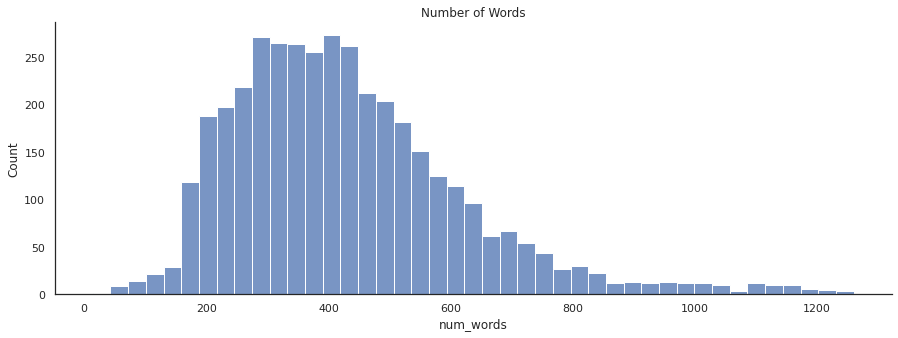

In [29]:
#compute the number of words in each essay
train['num_words'] = train['full_text'].apply(lambda x: len(x.split()))

#plot the distribution of the number of words
with sns.axes_style("white"):
  fig = plt.figure(figsize=(15, 5))
  sns.histplot(data=train, x="num_words")
  plt.title("Number of Words")
  sns.despine()
  sns.set_context("poster")
  plt.show()


# Try density plot to make the graph easier to read. 
# remove the axis lines
# increase axis text size to 14
# Increase title size to 20

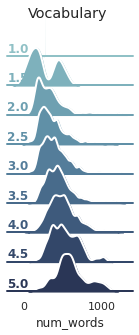

In [30]:
ridge_plot(train, 'vocabulary', 'num_words')

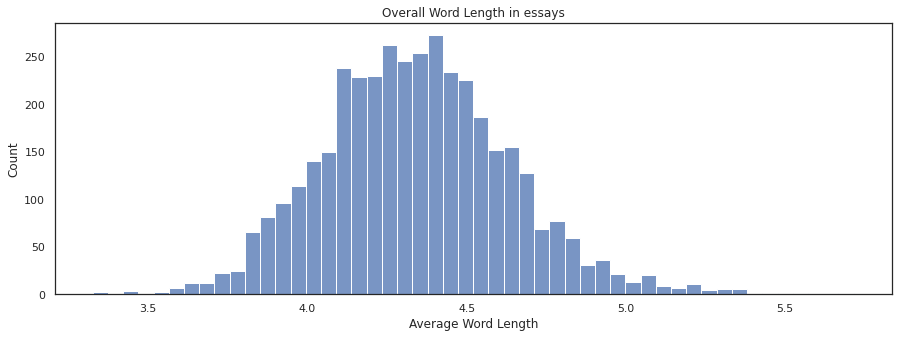

In [31]:
#compute the average length of words for each essay
train['mean_word_len'] = train['full_text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))

#plot the distribution of the average length of words
fig = plt.figure(figsize=(15, 5))
g = sns.histplot(data=train, x="mean_word_len")
g.set(xlabel = "Average Word Length", title = "Overall Word Length in essays")
plt.show()


In [32]:
# Try density plot to make the graph easier to read. 
# remove the axis lines
# increase axis text size to 14
# Increase title size to 20

Data across all output categories looks about normall distributed. May even be able to bin the results as scores ranging over dataset. 

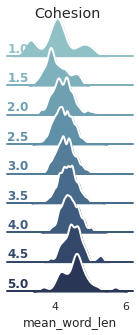

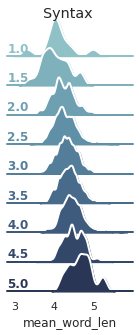

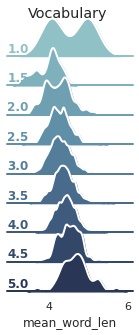

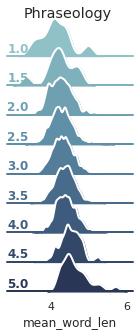

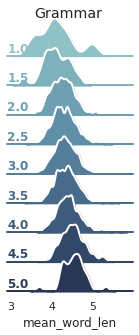

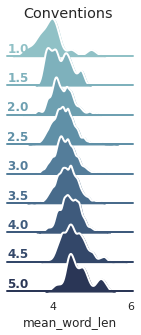

In [33]:
for index, category in enumerate(outcome_vars):
  ridge_plot(train, category, "mean_word_len")


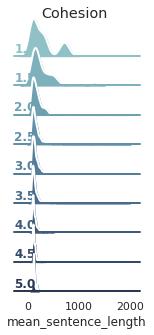

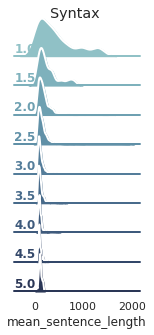

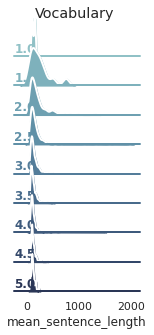

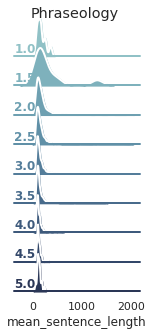

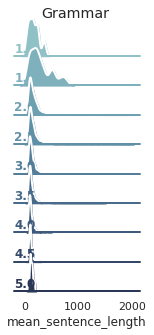

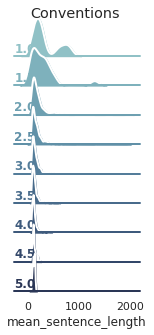

In [34]:
# lengths of sentences
train['mean_sentence_length'] = train['full_text'].str.split('\.').apply(lambda x : np.mean([len(i) for i in x]))

for index, category in enumerate(outcome_vars):
  ridge_plot(train, category, "mean_sentence_length")

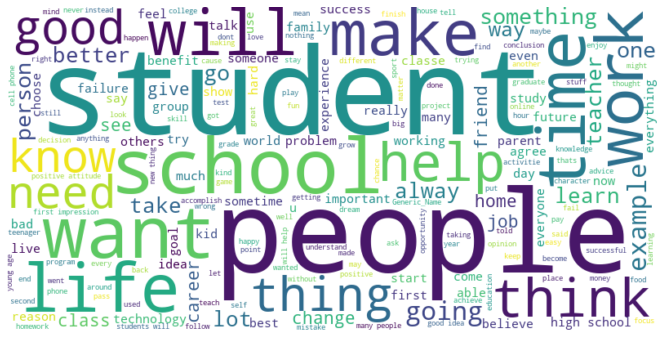

In [35]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(train['full_text']))
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
train.to_pickle("before_preprocessing_train.pkl")

In [37]:
# Read in preprocessed training data
train = pd.read_pickle('before_preprocessing_train.pkl')

# Preprocessing

In [38]:
# outputs are discrete rather than continuous
dtypes = {c: 'float64' for c in ('cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions')}
train = train.astype(dtypes)

### Feature engineering

In [39]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words,mean_word_len,mean_sentence_length
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,261,4.252874,72.052632
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,533,3.936210,174.733333
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,320,4.196875,82.200000
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,728,4.447802,106.405405
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,234,4.089744,330.750000


In [40]:
# One example
train[train['text_id'] == "7835355C55D8"].iloc[0, 1]

'Dear TEACHER_NAME,\n\nI WRITE THIS LETTER TO SAID THAT IS NOT FAIR THAT Only the people that have good grades can play in one of the sport. All the people with A, or B can play because the C is the baldest grade on the school. Because people'

In [41]:
train['total'] = train.iloc[:,2:].sum(axis=1)

train["result"] = 0

train.loc[train["total"] >= (30*0.62),"result"] = 1 

train["characters_unedited"] = train["full_text"].apply(len)

train['preprocessed_text'] = train['full_text'].apply(preprocessor)

train['tokenized'] = train['preprocessed_text'].apply(word_tokenize)

# Total words: 
train['total_words'] = train['tokenized'].apply(len)

# Unique words: 
train['unique_words'] = train['tokenized'].apply(lambda x: len(np.unique(x)))

# Stop words: 
train[['cleaned_text','stopword_count']] = train['preprocessed_text'].apply(stopword_removal)

# Unique words in cleaned text: 
train['cleaned_unique_words'] = train['cleaned_text'].apply(lambda x: len(np.unique(word_tokenize(x))))

train.to_pickle("feature_engineering_train.pkl")

train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words,mean_word_len,mean_sentence_length,total,result,characters_unedited,preprocessed_text,tokenized,total_words,unique_words,cleaned_text,stopword_count,cleaned_unique_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,261,4.252874,72.052632,357.305505,1,1387,i think that students would benefit from learn...,"[i, think, that, students, would, benefit, fro...",264,131,think students would benefit learning home won...,135,86
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,533,3.936210,174.733333,726.169543,1,2635,when a problem is a change you have to let it ...,"[when, a, problem, is, a, change, you, have, t...",536,136,problem change let best matter happening chang...,322,82
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,320,4.196875,82.200000,424.396875,1,1663,dear principal if u change the school policy o...,"[dear, principal, if, u, change, the, school, ...",330,115,dear principal u change school policy grade b ...,198,60
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,728,4.447802,106.405405,865.853208,1,3973,the best time in life is when you become yours...,"[the, best, time, in, life, is, when, you, bec...",757,204,best time life become agree greatest accomplis...,476,137
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,234,4.089744,330.750000,585.339744,1,1326,small act of kindness can impact in other peop...,"[small, act, of, kindness, can, impact, in, ot...",234,105,small act kindness impact people change people...,122,69


In [42]:
# check for puncuation removal
train.loc[(train['text_id'] == "7835355C55D8"), ['cleaned_text']]

,cleaned_text
1571,dear teacher_name write letter said fair peopl...


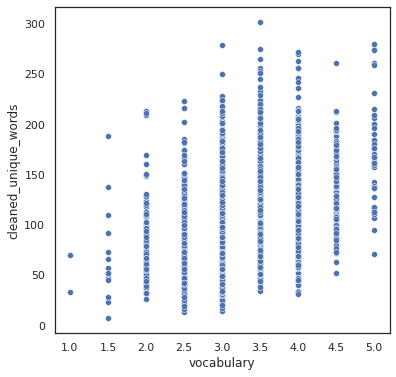

In [43]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = train, x = 'vocabulary', y = 'cleaned_unique_words')

In [44]:
# outputs are discrete rather than continuous
dtypes = {c: 'float64' for c in ('cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions')}
train = train.astype(dtypes)

In [45]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words,mean_word_len,mean_sentence_length,total,result,characters_unedited,preprocessed_text,tokenized,total_words,unique_words,cleaned_text,stopword_count,cleaned_unique_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,261,4.252874,72.052632,357.305505,1,1387,i think that students would benefit from learn...,"[i, think, that, students, would, benefit, fro...",264,131,think students would benefit learning home won...,135,86
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,533,3.936210,174.733333,726.169543,1,2635,when a problem is a change you have to let it ...,"[when, a, problem, is, a, change, you, have, t...",536,136,problem change let best matter happening chang...,322,82
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,320,4.196875,82.200000,424.396875,1,1663,dear principal if u change the school policy o...,"[dear, principal, if, u, change, the, school, ...",330,115,dear principal u change school policy grade b ...,198,60
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,728,4.447802,106.405405,865.853208,1,3973,the best time in life is when you become yours...,"[the, best, time, in, life, is, when, you, bec...",757,204,best time life become agree greatest accomplis...,476,137
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,234,4.089744,330.750000,585.339744,1,1326,small act of kindness can impact in other peop...,"[small, act, of, kindness, can, impact, in, ot...",234,105,small act kindness impact people change people...,122,69


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_id               3911 non-null   object 
 1   full_text             3911 non-null   object 
 2   cohesion              3911 non-null   float64
 3   syntax                3911 non-null   float64
 4   vocabulary            3911 non-null   float64
 5   phraseology           3911 non-null   float64
 6   grammar               3911 non-null   float64
 7   conventions           3911 non-null   float64
 8   num_words             3911 non-null   int64  
 9   mean_word_len         3911 non-null   float64
 10  mean_sentence_length  3911 non-null   float64
 11  total                 3911 non-null   float64
 12  result                3911 non-null   int64  
 13  characters_unedited   3911 non-null   int64  
 14  preprocessed_text     3911 non-null   object 
 15  tokenized            

In [47]:
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words,mean_word_len,mean_sentence_length,total,result,characters_unedited,total_words,unique_words,stopword_count,cleaned_unique_words
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.0,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,430.492969,4.341833,146.670907,600.127544,1.0,2334.522373,436.400665,150.777806,239.103043,99.972641
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,191.868449,0.293352,111.222022,231.548048,0.0,1033.406009,194.627395,50.025538,112.836352,39.985784
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,3.325879,32.266667,107.285714,1.0,82.000000,14.000000,13.000000,6.000000,7.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,294.000000,4.140311,94.599359,445.620187,1.0,1597.000000,298.000000,114.000000,160.000000,70.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,402.000000,4.333333,118.263158,563.799276,1.0,2173.000000,407.000000,145.000000,219.000000,94.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,526.500000,4.524188,163.281250,701.298210,1.0,2866.500000,534.500000,180.000000,293.000000,122.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1260.000000,5.714961,1990.333333,3127.072060,1.0,6044.000000,1268.000000,387.000000,820.000000,302.000000


There are barely any examples on the edges. Which probably explains the confusion matrix since it is so heavily weighted towards 3

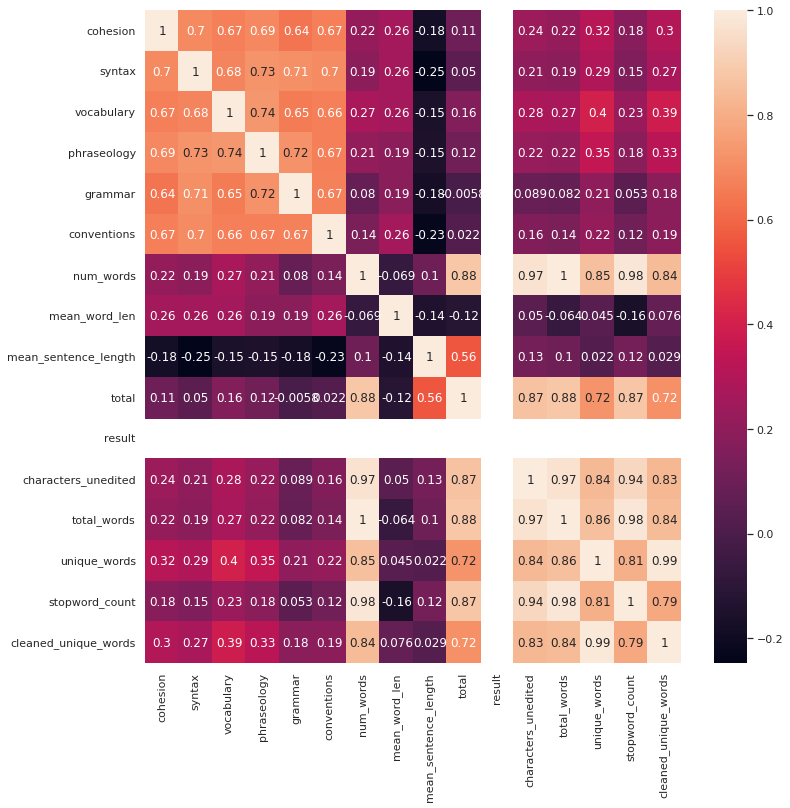

In [48]:
plt.rcParams['figure.figsize'] = [12,12]

h = sns.heatmap(train.select_dtypes(include=[np.floating, np.integer]).corr(), annot = True)

- Slight negative correlation between the length of sentences used and the outcome score. 
- The mean word length and stop word cont are slightly negatively correlated, but that makes sense. The stop words are generally shorter. 
- Unique words seems to be the strongest linear predictor of vocabulary. 
- Seems like the longer the sentences the lower the vocabulary score.

Unique words by scoring to create word cloud by score

In [49]:
cv = CountVectorizer(stop_words ='english')
data_cv = cv.fit_transform(train['cleaned_text'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = train.index
data_dtm.head()

,00,000,00am,00pm,02,03,04,08,0f,0nce,0r,0school,10,100,1000,10000,100000,100x,103,10k,10p,10pm,10th,10x,10years,10yr,11,111,11p,11pm,11th,12,120,123,12am,12pm,12th,13,14,145,15,150,15th,16,16th,17,1714,1769,17th,18,1800,1800s,1830,19,1900,1950,1960,1976,1978,1995,1996,1999,1am,1hour,1st,1v1,1weak,20,200,2000,2001,20019,2002,2006,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2025,2026,20th,20years,21,21st,22,22nd,23,24,24k,25,25mins,26,27,275,28,29,299,2brthers,2d,2nd,2pm,30,300,30am,30minites,30pm,31,311,3119,315,32,35,35am,360,365,37,375,38,385,3d,3h,3pm,3rd,3threet,3years,40,400,408,409,409th,41,42,432,45,46,47,48,48pm,4miles,4pm,4th,50,500,50s,52,53,55,56,58,5am,5min,5p,5pm,5th,5x,60,600,60s,62,65,67,69,6am,6pm,6th,70,700,75,78,79,7am,7hours,7pm,7th,80,800,80s,82,83,85,86,87,88,89,8am,8grade,8hrs,8pm,8th,90,900,90s,91,911,92,93,94,95,96,96c,98,99,9am,9p,9pm,9th,_and,_but,_yes,aachiveing,aand,ab,abalible,abandon,abandoned,abaut,abaute,abauth,abble,abc,abd,abdicating,abducted,abel,abiding,abilies,abilites,abiliti,abilities,abilitly,ability,abilityin,abillity,abilties,abilty,abiut,abke,abkle,abkt,abl,...,worldwide,worlk,worls,worlwild,worm,worms,worn,worng,worngly,worning,worote,worrid,worrie,worried,worries,worring,worry,worryed,worrying,worrys,worse,worsening,worser,worst,wort,worth,worthless,worths,worthwhile,worthy,wost,wot,woth,wotk,wotn,wotout,woud,woudn,woukd,woukld,woul,wouldbe,woulden,wouldl,wouldnt,wouldv,wouldve,woulike,woulld,wouln,woulnd,woulndn,wound,wounder,wounderful,woundn,wounld,wount,wouold,wow,wram,wrap,wreck,wrecking,wreds,wrench,wrenches,wrestler,wrestlering,wrestlers,wrestling,wright,wrighting,wrights,wrinkled,wrinting,write,writen,writer,writering,writers,writes,writhing,writing,writng,writte,written,writting,wrk,wrok,wroking,wrold,wron,wrong,wrongful,wronging,wrongly,wrongs,wror,wrose,wrote,wroth,wroug,wroung,wrx,wse,wuld,wuold,wuth,ww2,wwekday,wwi,wwii,wwith,www,xample,xbox,xin,xylophone,ya,yaars,yaers,yake,yall,yang,yank,yard,yards,yay,yea,yeaer,yeah,year,yearbook,yearbooks,yearly,yearned,years,yeas,yeat,yeling,yell,yelled,yelling,yellow,yells,yep,yeras,yes,yesterday,yhat,yhey,yhour,yo,yoga,yogurt,yong,yonge,yonger,yoo,yoose,yoou,yopu,yor,york,yorself,yos,yotu,youa,youar,youare,youas,youcan,youcant,youe,youg,youir,youjr,youll,youlself,youmaybe,youn,yound,young,youngboy,younger,youngers,youngerts,youngest,youngets,youngs,youngsters,youngues,youor,youre,yourger,yourlife,yourmind,yours4elf,yourseif,yoursel,yourselfe,yourselfs,yourserf,yourslaf,yourslef,yourslfe,yourtrue,yous,youse,youself,youselt,yout,youth,youthness,youtube,youtuber,youtubers,youu,youv,youve,youy,ypour,ypu,ypur,yu,yubetube,yuears,yummy,yung,yuo,yuor,yurself,yyou,zambia,zealous,zelda,zentangle,zere,zero,zip,zombie,zone,zones,zoning,zonned,zoo,zoology,zore,zurkrbuirg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [50]:
# Let's pickle it for later use
data_dtm.to_pickle("dtm.pkl")

In [51]:
# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
train.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

## Creating Word Clouds

In [52]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

In [53]:
q = ''.join(["vocabulary==",str(1)])
q

'vocabulary==1'

In [54]:
scores = [i/2 for i in range(2, 11)]
scores

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [55]:
num_keep = 30

word_keeper = {}

ws_counter = {}

for s in scores:
  q = ''.join(["vocabulary==",str(s)]) 
  words = Counter()
  for v in train.query(q)['cleaned_text']:
    words.update(tokenizer.tokenize(v))
  ws_counter[s] = words.most_common(num_keep)
  top_words = list(dict(ws_counter[s]).keys())
  word_keeper[s] = top_words

vocab_top_words = pd.DataFrame.from_dict(word_keeper)
vocab_top_words

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,student,life,people,people,people,people,students,students,people
1,offer,work,school,school,school,students,people,people,school
2,distance,people,good,students,students,school,school,school,students
3,learning,school,life,good,good,time,time,time,would
4,option,good,students,like,work,get,get,life,life
5,one,need,think,time,get,would,would,get,technology
6,attend,like,like,work,like,like,work,one,time
7,online,que,one,want,time,good,good,would,one
8,pr,group,help,get,want,work,like,make,world
9,video,go,work,life,life,life,want,help,also


Update Stop words

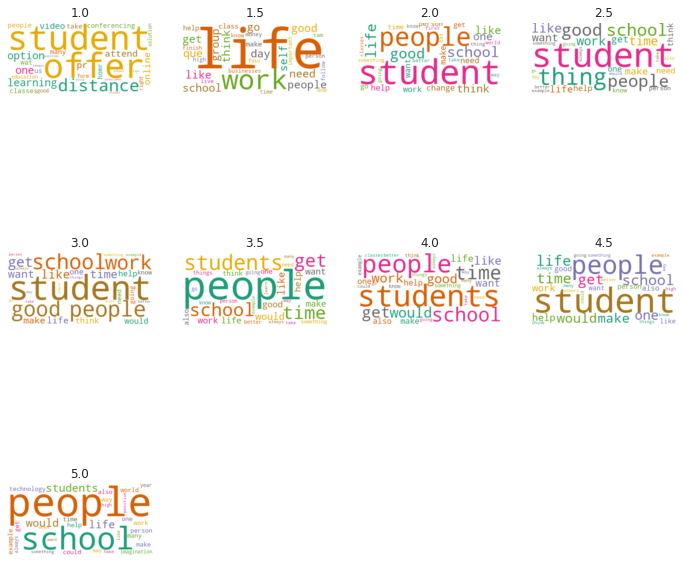

In [56]:
# Creating Graphs
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

for index, score in enumerate(vocab_top_words.columns):
  wc.generate(' '.join(vocab_top_words[score]))
   
  plt.subplot(3, 4, index+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.title(score)


### **Findings**
Many of the same words are repeated which might be making the classification difficult. Adding them to the stop words to be removed during processing. 

In [57]:
stopword_id = Counter()
for k in word_keeper.keys(): 
  stopword_id.update(word_keeper[k])

add_stop_words = [word for word, count in stopword_id.most_common() if count > len(scores)/2]

print(f"Total number of stop words across scores {len(stopword_id.most_common())}")
print(f"Number of stop words adding to preprocessor: {len(add_stop_words)}")

Total number of stop words across scores 79
Number of stop words adding to preprocessor: 30


In [58]:
from sklearn.feature_extraction import text 
print(f"Length of stop words from nltk: {len(set(stopwords.words('english')))}")
print("-"*20)
print("Length of stop words from sklearn before addition: ", len(text.ENGLISH_STOP_WORDS))
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
print("-"*20)
print("Afterwards: ", len(stop_words))

Length of stop words from nltk: 179
--------------------
Length of stop words from sklearn before addition:  318
--------------------
Afterwards:  339


In [59]:
print("Before second stop word cleaning")
train[['cleaned_text', 'stopword_count']].describe(include = 'all')

Before second stop word cleaning


,cleaned_text,stopword_count
count,3911,3911.000000
unique,3911,NaN
top,think students would benefit learning home won...,NaN
freq,1,NaN
mean,NaN,239.103043
std,NaN,112.836352
min,NaN,6.000000
25%,NaN,160.000000
50%,NaN,219.000000
75%,NaN,293.000000


In [60]:
# Second stop word removal
temp = train['cleaned_text'].apply(stopword_removal)
train['stopword_count'] = train['stopword_count'] + temp[1]
train['cleaned_text'] = temp[0]

print("After second stop word cleaning")
train[['cleaned_text', 'stopword_count']].describe()

After second stop word cleaning


,stopword_count
count,3911.000000
mean,308.455382
std,141.627993
min,8.000000
25%,208.000000
50%,286.000000
75%,377.000000
max,1038.000000


Standardization

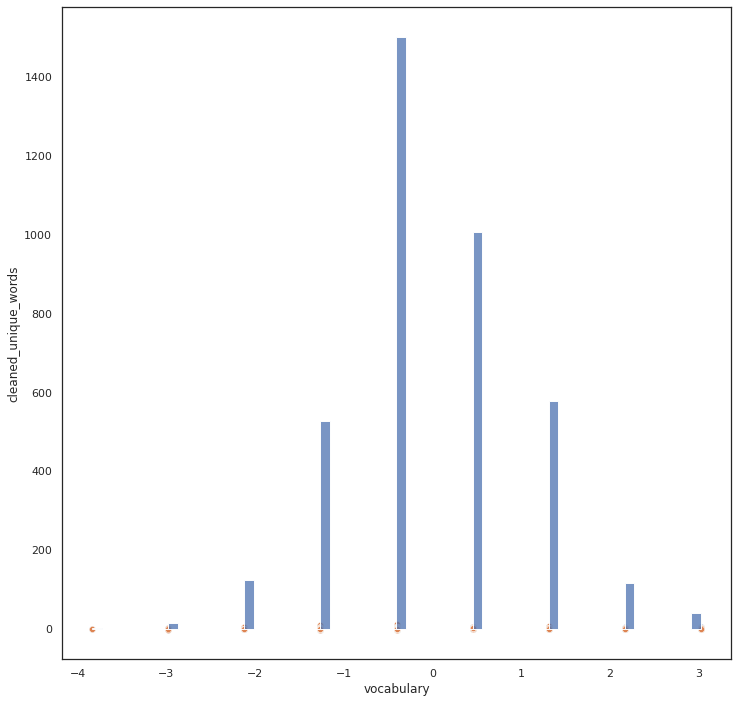

In [61]:
train_std = train.copy()
train_std[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'total', 'result', 'characters_unedited', 'total_words', 'unique_words', 'stopword_count', 'cleaned_unique_words']] = StandardScaler().fit_transform(train_std[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'total', 'result', 'characters_unedited', 'total_words', 'unique_words', 'stopword_count', 'cleaned_unique_words']])

train_std.head()
train_std.describe()

sns.scatterplot(data = train_std, x = 'vocabulary', y = 'cleaned_unique_words')
sns.scatterplot(data = train_std, x = 'vocabulary', y = 'total')
sns.histplot(data = train_std, x = 'vocabulary')

In [62]:
# standardization to center the feature columns at mean 0 and std 1. 

# train_std = train.select_dtypes(include=[np.floating, np.integer])
# sc_x = StandardScaler()

# # standardize all non string/object columns
# train_std = pd.DataFrame(sc_x.fit(train_std).transform(train_std), columns = train_cols)

In [63]:
#pickle preprocessed training set for later
train.to_pickle("training_set.pkl")

# Model Building

Changed "full_text" to "cleaned_text" 20221126

In [64]:
df_vocab = train[['cleaned_text', 'total_words', 'unique_words', 'stopword_count', 'cleaned_unique_words','vocabulary']]
df_vocab.head()

,cleaned_text,total_words,unique_words,stopword_count,cleaned_unique_words,vocabulary
0,benefit learning home wont change early mornin...,264,131,174,86,3.0
1,problem change let best matter happening chang...,536,136,422,82,3.0
2,dear principal u change policy grade b average...,330,115,247,60,3.0
3,best agree greatest accomplishment world const...,757,204,573,137,4.5
4,small act kindness impact change persons impac...,234,105,166,69,3.0


In [65]:
df_vocab.columns

Index(['cleaned_text', 'total_words', 'unique_words', 'stopword_count', 'cleaned_unique_words', 'vocabulary'], dtype='object')

In [66]:
target_vocab = df_vocab.pop('vocabulary')

In [67]:
target_vocab.head()

0    3.0
1    3.0
2    3.0
3    4.5
4    3.0
Name: vocabulary, dtype: float64

In [68]:
data_vocab_tf = tf.data.Dataset.from_tensor_slices(
    (df_vocab[['cleaned_text']].values, target_vocab.values)
)

In [69]:
# inspection of the first 5 examples
# for example in data_vocab_tf.take(5):
  # print review (first 40 characters) and sentiment (label)
  # tf.print(example[0].numpy())
  # tf.print(example[0].numpy()[0][:40], example[1])

In [70]:
tf.random.set_seed(26)
# splitting the datasets
splits = [0.6, 0.2, 0.2]

df_shape = df_vocab.shape[0]

data_vocab_tf = data_vocab_tf.shuffle(
    df_shape, reshuffle_each_iteration=False
)

# Look at doing a train test split with tensor flow
data_vocab_tf_test = data_vocab_tf.take(int(df_shape * splits[2]))
data_vocab_tf_train_valid = data_vocab_tf.skip(int(df_shape * splits[2]))
data_vocab_tf_train = data_vocab_tf_train_valid.take(int(df_shape * splits[0]))
data_vocab_tf_valid = data_vocab_tf_train_valid.skip(int(df_shape * splits[0]))

In [71]:
def shuffle_data(): 
  tf.random.set_seed(26)
# splitting the datasets
  splits = [0.6, 0.2, 0.2]

  df_shape = df_vocab.shape[0]

  data_vocab_tf = data_vocab_tf.shuffle(
      df_shape, reshuffle_each_iteration=False
  )

  # Look at doing a train test split with tensor flow
  data_vocab_tf_test = data_vocab_tf.take(int(df_shape * splits[2]))
  data_vocab_tf_train_valid = data_vocab_tf.skip(int(df_shape * splits[2]))
  data_vocab_tf_train = data_vocab_tf_train_valid.take(int(df_shape * splits[0]))
  data_vocab_tf_valid = data_vocab_tf_train_valid.skip(int(df_shape * splits[0]))

  return data_vocab_tf_test, data_vocab_tf_train_valid, data_vocab_tf_train, data_vocab_tf_valid

What is a take class? 

ID unique words (tokens) in training dataset

In [72]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_vocab_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 15722


Rowwise take each essay, process into lower case, remove stop words, remove numbers or change to text.
Look at frequency of words. 
Create tokens that are appropriate and generalizable to the entire dataset

In [73]:
word_frequencies = pd.DataFrame(token_counts.most_common())
word_frequencies.head()

,0,1
0,learn,2221
1,day,2057
2,classes,2032
3,home,1858
4,lot,1852


In [74]:
word_frequencies = word_frequencies.rename({0:"x", 1:"y"}, axis = 1)
word_frequencies.describe()

,y
count,15722.000000
mean,19.019145
std,95.575416
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,2221.000000


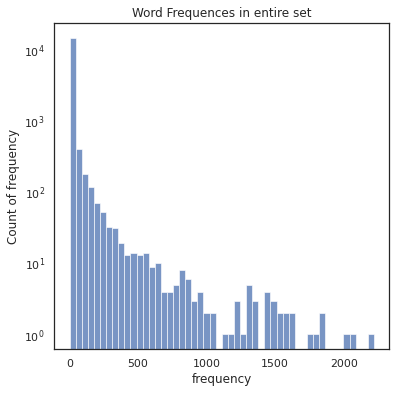

In [75]:
plt.figure(figsize = [6,6])
p = sns.histplot(data = word_frequencies, x = "y", bins = 50)
p.set(title = "Word Frequences in entire set", xlabel = 'frequency', ylabel = "Count of frequency")
p.set_yscale('log')

[Q] Would weighting the embeddings for the mdoels based on the number of examples help? 

Number of Unique words by score

In [76]:
# # Misspellings might be found in those that are not frequent
# bag_of_words = word_frequencies.query("y > 10 and y < 3000")["x"].to_list()
# print(len(bag_of_words))
# print(bag_of_words[1:5])

Encoding sequences of words into sequences of integers

In [77]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

data_vocab_tf_train = data_vocab_tf_train.map(encode_map_fn)
data_vocab_tf_train_valid = data_vocab_tf_train_valid.map(encode_map_fn)
data_vocab_tf_test = data_vocab_tf_test.map(encode_map_fn)

(array([ 23.,  64., 125., 212., 257., 278., 255., 203., 207., 178., 131.,
        101.,  81.,  46.,  45.,  34.,  35.,  20.,  12.,  12.,   7.,   4.,
          2.,   2.,   1.,   4.,   1.,   1.,   1.,   4.]),
 array([1.08 , 1.169, 1.258, 1.347, 1.436, 1.525, 1.614, 1.703, 1.792,
        1.881, 1.97 , 2.059, 2.148, 2.237, 2.326, 2.415, 2.504, 2.593,
        2.682, 2.771, 2.86 , 2.949, 3.038, 3.127, 3.216, 3.305, 3.394,
        3.483, 3.572, 3.661, 3.75 ]),
 <a list of 30 Patch objects>)

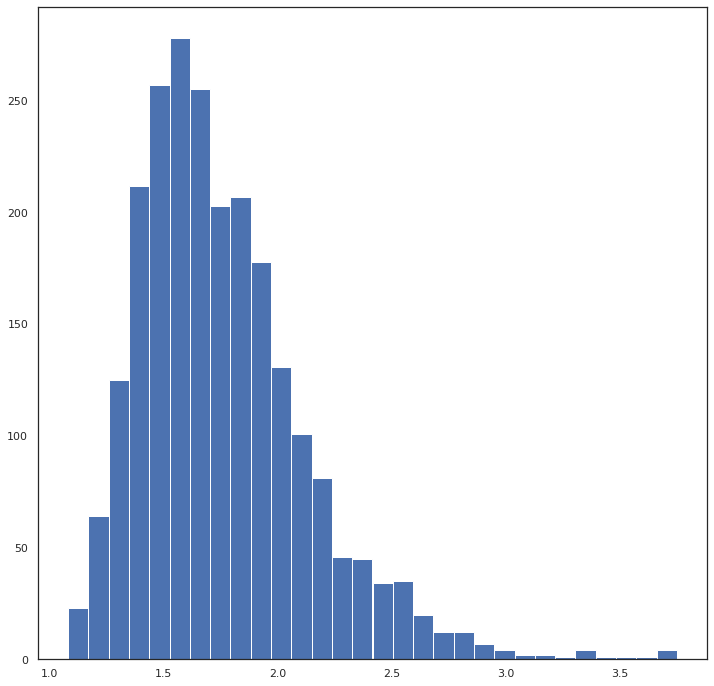

In [78]:
# print first two examples in training data
word_ratio = []
for example in data_vocab_tf_train:
    # print ('----------------------------')
    # print('Sequence length:', example[0].shape)
    # print('Unique words', len(np.unique(example[0])))
    # print("Ratio length to unique words", (example[0].shape[0]/len(np.unique(example[0]))))
    word_ratio.append((example[0].shape[0]/len(np.unique(example[0]))))

    # print('Integer sequence:\n', example[0].numpy())
plt.hist(word_ratio, bins = 30)

Divide the dataset into mini-batches as input to the model

In [79]:
batch_size = 32

def batch_data(data, batch_size = 64):
    batch =  data.padded_batch(batch_size, padded_shapes = ([-1], [])) 
    print(type(batch))
    return batch

# batcing of training, validation and test partitions
train_data = batch_data(data_vocab_tf_train)
valid_data = batch_data(data_vocab_tf_train_valid)
test_data = batch_data(data_vocab_tf_test)

<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>


Average sequence length in training mini-batches: 317


Text(0.5, 0, 'Sequence length')

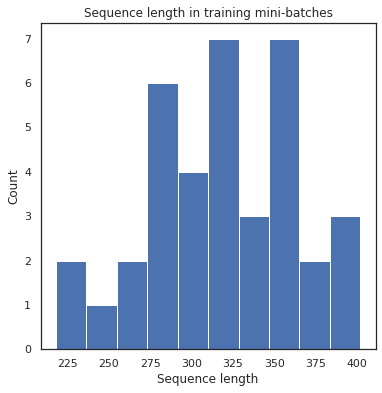

In [80]:
# histogram of sequence length in training mini-batches
seq_len_train = []

for batch in train_data:
    seq_len_train.append(batch[0].shape[1])
    
print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)
plt.rcParams['figure.figsize'] = [6, 6]
# # histogram
plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length')

Look at relationships between: (Harry has done some of this already) 
- Length v. Outcome
- Unique words v. Outcome

Look into Transfer Learning Approach to Build model
BERT model

## Model Building
- Modified Cornelia's example for our purposes

In [81]:
def create_test_ground_truth(test_data): 
  """
  Pull labels from test set to look at how accurate model was. 

  Extended description of function.

  Parameters:
    test_data (tensor object): Description of arg1

  Returns:
    int: Description of return value

  """

  true_labels = np.empty(0)
  for k, v in test_data.enumerate():
    true_labels = np.concatenate((true_labels, v[1].numpy()))

  print(true_labels.shape)

  ground_truth = Counter(true_labels)

  return ground_truth

In [82]:
true_labels = np.empty(0)
for k, v in test_data.enumerate():
  true_labels = np.concatenate((true_labels, v[1].numpy()))

print(true_labels.shape)

ground_truth = Counter(true_labels)

(782,)


In [83]:
train.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'num_words', 'mean_word_len', 'mean_sentence_length', 'total', 'result', 'characters_unedited', 'preprocessed_text', 'tokenized', 'total_words', 'unique_words', 'cleaned_text', 'stopword_count', 'cleaned_unique_words'], dtype='object')

Including base features to run models without preprocessing the data to compare how useful our preprocessing was. 

In [84]:
base_features = ['full_text', ]

In [85]:
features = ['total_words', 'unique_words', 'stopword_count', 'cleaned_unique_words']

In [86]:
target = 'vocabulary'

print("Potential outcome variables to look out: ", outcome_vars)
print("---")
print("Current outcome variable evaluating: ", target)



Potential outcome variables to look out:  ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
---
Current outcome variable evaluating:  vocabulary


## Simple Model
Underlying base model to use as comparison. 
We assume that a model will have at least a 50% accuracy if it only predicts 3 each time.  

### Data Setup

In [167]:
# Data cleaning proces: 
target = "cohesion"
# First pass
train['full_text'] = train['full_text'].apply(preprocessor)

# Second pass to remove stop words
# train[['full_text', 'stopword_count']] = train['full_text'].apply(stopword_removal)
# train['full_text'].head()

# outputs are discrete rather than continuous
dtypes = {c: 'float64' for c in ('cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions')}
train = train.astype(dtypes)

df_vocab = train[['full_text', target]]

# scale vocab to be 0-4
print("before scaling: ")
print(train[target].describe())

train[target] = train[target] - 1
target_vocab = df_vocab.pop(target)
target_vocab.head()

print("after scaling: ")
print(train[target].describe())

# 
data_vocab_tf = tf.data.Dataset.from_tensor_slices(
    (df_vocab[['full_text']].values, target_vocab.values)
)

tf.random.set_seed(26)
# splitting the datasets
splits = [0.6, 0.2, 0.2]

df_shape = df_vocab.shape[0]

data_vocab_tf = data_vocab_tf.shuffle(
    df_shape, reshuffle_each_iteration=True
)

# Look at doing a train test split with tensor flow
data_vocab_tf_test = data_vocab_tf.take(int(df_shape * splits[2]))
data_vocab_tf_train_valid = data_vocab_tf.skip(int(df_shape * splits[2]))
data_vocab_tf_train = data_vocab_tf_train_valid.take(int(df_shape * splits[0]))
data_vocab_tf_valid = data_vocab_tf_train_valid.skip(int(df_shape * splits[0]))

# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_vocab_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

data_vocab_tf_train = data_vocab_tf_train.map(encode_map_fn)
data_vocab_tf_train_valid = data_vocab_tf_train_valid.map(encode_map_fn)
data_vocab_tf_test = data_vocab_tf_test.map(encode_map_fn)

batch_size = 32

def batch_data(data, batch_size = 64):
    batch =  data.padded_batch(batch_size, padded_shapes = ([-1], [])) 
    print(type(batch))
    return batch

# batcing of training, validation and test partitions
train_data = batch_data(data_vocab_tf_train)
valid_data = batch_data(data_vocab_tf_train_valid)
test_data = batch_data(data_vocab_tf_test)

true_test_labels = create_test_ground_truth(test_data)
print(true_test_labels)


before scaling: 
count    3911.000000
mean        2.127077
std         0.662542
min         0.000000
25%         1.500000
50%         2.000000
75%         2.500000
max         4.000000
Name: cohesion, dtype: float64
after scaling: 
count    3911.000000
mean        1.127077
std         0.662542
min        -1.000000
25%         0.500000
50%         1.000000
75%         1.500000
max         3.000000
Name: cohesion, dtype: float64
Size of training vocabulary: 16125
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
(782,)
Counter({2.0: 196, 2.5: 185, 1.5: 174, 3.0: 109, 1.0: 83, 3.5: 26, 4.0: 6, 0.5: 3})


In [168]:
def simple_model():
  """
    Return a simple logistic regression model using the Keras Sequential API.
    Using to set a baseline for the model building
  """

  vocab_train_size = len(token_counts) + 2
  max_sequence_length = 100

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  # model.add(vectorize_layer)
  model.add(tf.keras.layers.Embedding(
      input_dim = vocab_train_size,  # size of feature vocabulary
      output_dim = 2,  # embedding dimension
      input_length = max_sequence_length  # number of inputs
      ))

  # Average over the sequence dimension, so each review is represented by 
  # 1 vector of size embedding_dimension
  model.add(tf.keras.layers.GlobalAveragePooling1D()) 

  # Alternatively, we could concatenate the embedding representations of 
  # all tokens in the movie review
  # model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=256,        
      activation='relu'))
  
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
    units=256,        
    activation='relu'))
  
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
    units=1,        
    activation='relu'))

  model.compile(loss='mse', 
                optimizer='adam',
                metrics=['accuracy'])
  
  return model

# Build a model
sim_model = simple_model()
sim_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 2)            32254     
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               768       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

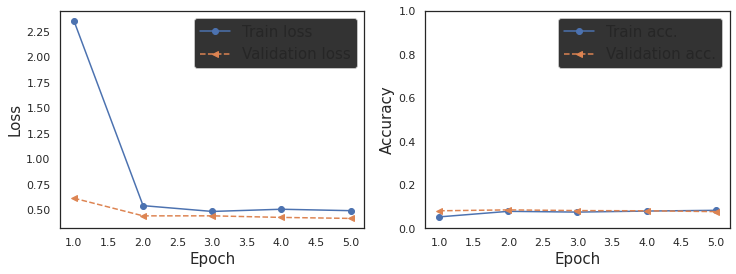

13/13 [==============================] - 0s 35ms/step - loss: 0.4558 - accuracy: 0.0959

Test Acc. 9.59%


In [169]:
history = sim_model.fit(
  train_data,  # our sparse padded training data
  validation_data = valid_data,  # corresponding labels
  epochs=5,    # number of passes through the training data
  verbose=0     # display some progress output during training
  )

plot_history(history)
# history.history

sim_model.predict(test_data)

# Model evaluation: 
test_results = sim_model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [90]:
predictions = sim_model.predict(test_data)

13/13 [==============================] - 1s 38ms/step


In [186]:
prediction_labels =  [float(scores[np.argmax(p)])for p in predictions]

In [91]:
# def numpy_summary(ar): 
#   stats = {}
#   stats['min'] = np.min(ar)
#   stats['25%'] = np.quantile(ar, 0.25)
#   stats['median'] = np.quantile(ar, 0.5)
#   stats['75%'] = np.quantile(ar, 0.75)
#   stats['max'] = np.max(ar)
#   stats['mean'] = np.mean(ar)

#   stats = pd.DataFrame.from_dict(stats, orient = 'index')

#   return stats

In [185]:
numpy_summary(predictions)

,0
min,0.000002
25%,0.000011
median,0.005604
75%,0.186453
max,0.480157
mean,0.111111


Test results for simple model are < 0.000

In [180]:
true_labels = np.empty(0)
for k, v in test_data.enumerate():
  true_labels = np.concatenate((true_labels, v[1].numpy()))

true_labels.shape

u, c = np.unique(true_labels, return_counts = True)
pd.Series(c, index = u)

0.0      2
0.5      2
1.0     62
1.5    141
2.0    242
2.5    193
3.0    111
3.5     27
4.0      2
dtype: int64

In [182]:
true_labels

array([2.5, 2. , 2. , 2. , 2.5, 1.5, 3. , 1.5, 1.5, 2. , 2. , 3. , 1.5,
       3. , 2.5, 1.5, 2.5, 2.5, 2.5, 3. , 3.5, 2. , 2.5, 2.5, 3.5, 1.5,
       1.5, 2. , 1.5, 3. , 3.5, 2.5, 2.5, 2. , 2. , 2. , 1.5, 1.5, 1. ,
       1.5, 3. , 1. , 2. , 3. , 3. , 3. , 1.5, 3.5, 2.5, 1.5, 2. , 2. ,
       2. , 3. , 1.5, 1.5, 2. , 2.5, 2. , 1.5, 2. , 2. , 2.5, 3. , 2. ,
       2.5, 1.5, 2. , 1.5, 1.5, 2.5, 2. , 2. , 2. , 2.5, 1. , 2.5, 2.5,
       2.5, 2.5, 2.5, 2. , 2. , 1. , 2.5, 3. , 2.5, 1. , 2.5, 1.5, 2. ,
       2.5, 2. , 1. , 2.5, 2. , 1. , 3. , 4. , 2. , 1. , 1.5, 2.5, 3. ,
       1. , 1.5, 2. , 3. , 3. , 2.5, 1.5, 2. , 2. , 1.5, 1.5, 2.5, 1.5,
       1.5, 2. , 2. , 2.5, 2. , 3. , 3. , 3.5, 3. , 2.5, 2. , 2. , 1.5,
       2. , 1. , 2. , 2.5, 2.5, 2. , 2.5, 3. , 2. , 2. , 2.5, 2. , 1.5,
       2. , 2.5, 2. , 1.5, 1.5, 3. , 3. , 2. , 2. , 2.5, 3. , 1.5, 2. ,
       2.5, 2. , 3. , 1. , 2.5, 2.5, 1.5, 1.5, 2. , 2.5, 2. , 3. , 3. ,
       2.5, 2.5, 3. , 2. , 2. , 3. , 1. , 1.5, 1.5, 1.5, 2. , 2.

In [183]:
prediction_labels

['2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',
 '2.5',


In [181]:
true_labels - prediction_labels

UFuncTypeError: ignored

In [93]:
ground_truth

Counter({2.5: 104,
         3.0: 309,
         2.0: 20,
         3.5: 199,
         4.0: 115,
         4.5: 23,
         1.5: 4,
         5.0: 8})

## Bigger Model

Models to try: 
Optimizers: 
- Adam
- 

Loss functions to try: 
- Mean Squared Error
- Logistic
- SparseCategoricalCrossentropy
- CategoricalCrossEntropy
- CosineSimilarity

In [94]:
def bigger_model(): 
  """
  Preprocessing reference # https://www.tensorflow.org/guide/keras/preprocessing_layers?authuser=1
  This model does not do the vectorization, assumes that has already been taken care of
  """
  vocab_train_size = len(token_counts) + 2
  
  output_dim = 32 # 128 -> 128 -> 32
  average_over_positions = True

  #   Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(26)

  model = tf.keras.Sequential()

    # Embedd
  model.add(
      tf.keras.layers.Embedding(
          input_dim = vocab_train_size, 
          output_dim = output_dim, 
          input_length = 100, # Limiting length of sentence to 100 tokens
          name = 'embedding'
      )
  )

  # Pooling layer
  # Average over the sequence dimension, so each essay is represented by 
  # 1 vector of size embedding_dimension

  model.add(tf.keras.layers.GlobalAveragePooling1D(name = "pooling")) 

  model.add(tf.keras.layers.Dense(
      units=128,        
      activation='relu', 
      name = 'relu1'))
  
  # add Dropout for regularization
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
      units=64,        
      activation='relu', 
      name = 'relu2'))
  
  model.add(tf.keras.layers.Dense(
        units=1,  # remember it's a multiclass classification problem
        use_bias=True,
        activation='sigmoid', # remember it's a multiclass classification problem
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        name='Output'
  ))

  model.compile(
      loss=tf.keras.losses.MeanSquaredLogarithmicError(),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
      metrics=['accuracy']
  )

  return model

big_model = bigger_model()
# model = model_compiler(model)

# Display the model layers
inspect_model(big_model)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           516064    
                                                                 
 pooling (GlobalAveragePooli  (None, 32)               0         
 ng1D)                                                           
                                                                 
 relu1 (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 relu2 (Dense)               (None, 64)                8256      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                        

None

'Embeddings layer - shape: '

(16127, 32)

'Embeddings layer - parameter matrix (before training): '

array([[-0.01467858,  0.03510207,  0.02359806, ..., -0.01600895,
        -0.04696453, -0.00888711],
       [ 0.04109618, -0.0213909 , -0.02313428, ..., -0.04247023,
        -0.01352608, -0.00623407],
       [-0.0063289 , -0.03715938, -0.02096692, ...,  0.01579097,
        -0.03263713, -0.0428754 ],
       ...,
       [-0.00597457,  0.00243939, -0.00963948, ...,  0.02327641,
        -0.03870857,  0.0452597 ],
       [ 0.01880595,  0.03339901,  0.0270367 , ...,  0.04491229,
         0.02251171, -0.03301032],
       [-0.03521262,  0.01732593,  0.00113236, ...,  0.04585295,
        -0.02751445,  0.02279383]], dtype=float32)

In [95]:
# history = big_model.fit(
#   train_data,  # our sparse padded training data
#   validation_data = valid_data,  # corresponding labels
#   epochs=5,    # number of passes through the training data
#   verbose=0     # display some progress output during training
#   )

# plot_history(history)
# # history.history

# big_model.predict(test_data)

# # Model evaluation: 
# test_results = big_model.evaluate(test_data)
# print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

## Logistic Model

In [96]:
# # try and except the TF tokenizer
# try:
#     tokenizer = tfds.features.text.Tokenizer()
# except AttributeError:
#     tokenizer = tfds.deprecated.text.Tokenizer()

# # create an instance of the Counter class
# token_counts = Counter()

# for example in data_vocab_tf_train:
#     tokens = tokenizer.tokenize(example[0].numpy()[0])
#     token_counts.update(tokens)
    
# print('Size of training vocabulary:', len(token_counts))

In [97]:
vocab_train_size = 1000

In [150]:
def logistic_model():
  """
    Return a simple logistic regression model using the Keras Sequential API.
    Using to set a baseline for the model building
  """

  vocab_train_size = len(token_counts) + 2
  
  output_dim = 32 # 128 -> 128 -> 32
  average_over_positions = True

  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(26)

  model = tf.keras.Sequential()

  # Embedd
  model.add(
      tf.keras.layers.Embedding(
          input_dim = vocab_train_size, 
          output_dim = output_dim, 
          input_length = 100, # Limiting length of sentence to 100 tokens
          name = 'embedding'
      )
  )

  # Pooling layer
  # Average over the sequence dimension, so each essay is represented by 
  # 1 vector of size embedding_dimension
  model.add(tf.keras.layers.GlobalAveragePooling1D(name = "pooling")) 
  
  # create output layer
  model.add(tf.keras.layers.Dense(
        units=1,  # remember it's a multiclass classification problem
        use_bias=True,
        activation='sigmoid', # remember it's a multiclass classification problem
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        name='Output'
  ))

# Use Categorical Crossentropy as our loss and the SGD optimizer.
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
      metrics=['accuracy']
  )

  return model

# Build a model
log_model = logistic_model()
log_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           516064    
                                                                 
 pooling (GlobalAveragePooli  (None, 32)               0         
 ng1D)                                                           
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 516,097
Trainable params: 516,097
Non-trainable params: 0
_________________________________________________________________


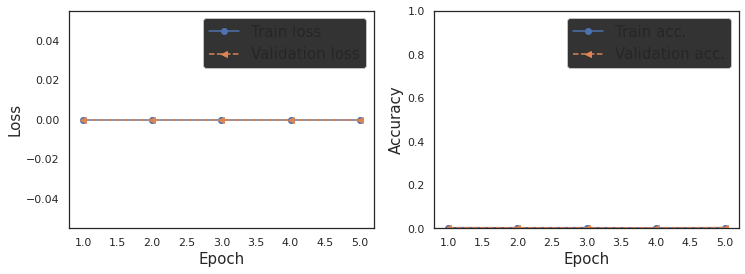

13/13 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 0.0038

Test Acc. 0.38%


In [151]:
history = log_model.fit(
  train_data,  # our sparse padded training data
  validation_data = valid_data,  # corresponding labels
  epochs=5,    # number of passes through the training data
  verbose=0     # display some progress output during training
  )

plot_history(history)
# history.history

log_model.predict(test_data)

# Model evaluation: 
test_results = log_model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

Feed forward NN Classifier, might help model building

## Categorical Model

### Data setup

In [100]:
train, test = load_fresh_dataset()

target = "cohesion"
# First pass
train['full_text'] = train['full_text'].apply(preprocessor)

# Second pass to remove stop words
train[['full_text', 'stopword_count']] = train['full_text'].apply(stopword_removal)
train['full_text'].head()

# outputs are discrete rather than continuous
dtypes = {c: 'float64' for c in ('cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions')}
train = train.astype(dtypes)

df_vocab = train[['full_text', target]]

# scale vocab to be 0-4
print("before scaling: ")
print(train[target].describe())

train[target] = train[target] - 1
target_vocab = df_vocab.pop(target)
target_vocab.head()

print("after scaling: ")
print(train[target].describe())

#
data_vocab_tf = tf.data.Dataset.from_tensor_slices(
    (df_vocab[['full_text']].values, target_vocab.values)
)

tf.random.set_seed(26)
# splitting the datasets
splits = [0.6, 0.2, 0.2]

df_shape = df_vocab.shape[0]

data_vocab_tf = data_vocab_tf.shuffle(
    df_shape, reshuffle_each_iteration=True
)

# Look at doing a train test split with tensor flow
data_vocab_tf_test = data_vocab_tf.take(int(df_shape * splits[2]))
data_vocab_tf_train_valid = data_vocab_tf.skip(int(df_shape * splits[2]))
data_vocab_tf_train = data_vocab_tf_train_valid.take(int(df_shape * splits[0]))
data_vocab_tf_valid = data_vocab_tf_train_valid.skip(int(df_shape * splits[0]))

# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_vocab_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

# drop some of the tokens


# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

data_vocab_tf_train = data_vocab_tf_train.map(encode_map_fn)
data_vocab_tf_train_valid = data_vocab_tf_train_valid.map(encode_map_fn)
data_vocab_tf_test = data_vocab_tf_test.map(encode_map_fn)

batch_size = 32

def batch_data(data, batch_size = 64):
    batch =  data.padded_batch(batch_size, padded_shapes = ([-1], [])) 
    print(type(batch))
    return batch

# batcing of training, validation and test partitions
train_data = batch_data(data_vocab_tf_train)
valid_data = batch_data(data_vocab_tf_train_valid)
test_data = batch_data(data_vocab_tf_test)

true_test_labels = create_test_ground_truth(test_data)
print(true_test_labels)

Train shape:  (3911, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB
None
Test shape:  (3, 2)
before scaling: 
count    3911.000000
mean        3.127077
std         0.662542
min         1.000000
25%         2.500000
50%         3.000000
75%         3.500000
max         5.000000
Name: cohesion, dtype: float64
after scaling: 
count    3911.000000
mean        2.127077
std         0.662542
min         0.000000
25%         1.500000
50%         2.000000
75%         2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 512)          8257024   
                                                                 
 pooling (GlobalAveragePooli  (None, 512)              0         
 ng1D)                                                           
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

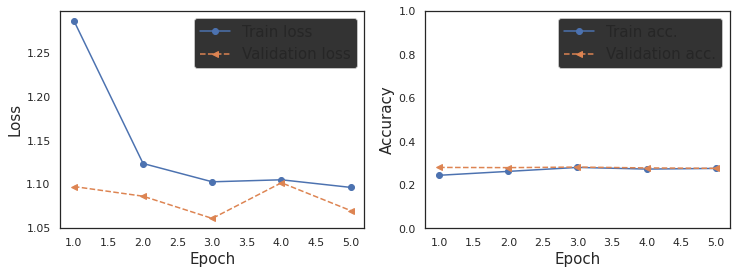

13/13 [==============================] - 1s 56ms/step - loss: 1.0702 - accuracy: 0.2852

Test Acc. 28.52%


In [196]:
epochs = 5
input_length = 500

vocab_train_size = len(token_counts) + 2

def categorical_model(input_length = 100): 
  """
  Preprocessing reference # https://www.tensorflow.org/guide/keras/preprocessing_layers?authuser=1
  This model does not do the vectorization, assumes that has already been taken care of. 
  Used when treating the labels as categories. 
  """

  """
  Summary line.

  Extended description of function.

  Parameters:
  arg1 (int): Description of arg1

  Returns:
  int: Description of return value

  """

  #   Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(26)

  model = tf.keras.Sequential()

    # Embedd
  model.add(
      tf.keras.layers.Embedding(
          input_dim = vocab_train_size, 
          output_dim = 512, 
          input_length = input_length, # Limiting length of sentence to 100 tokens
          name = 'embedding'
      )
  )

  # Pooling layer
  # Average over the sequence dimension, so each essay is represented by 
  # 1 vector of size embedding_dimension

  model.add(tf.keras.layers.GlobalAveragePooling1D(name = "pooling")) 
  
  model.add(tf.keras.layers.Dense(
      units=128,        
      activation='relu'))
  
  # add Dropout for regularization
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
      units=128,        
      activation='relu'))
  
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
      units=32,        
      activation='relu'))
  
  model.add(Dropout(0.5))

  # model.add(
  #     tf.keras.layers.Softmax(
          
  #     )
  # )

  model.add(tf.keras.layers.Dense(
        units=9,  # remember it's a multiclass classification problem
        use_bias=True,
        activation='softmax', # remember it's a multiclass classification problem
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        name='Output'
  ))

  model.compile(
    optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'])
  return model

cat_model = categorical_model(input_length)
cat_model.summary()

cat_history = cat_model.fit(
  train_data,  # our sparse padded training data
  validation_data = valid_data,  # corresponding labels
  epochs=epochs,    # number of passes through the training data
  verbose=0     # display some progress output during training
  )

cat_history.history

plot_history(cat_history)
# history.history

predictions = cat_model.predict(test_data)

# Model evaluation: 
test_results = cat_model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

**Findings**

In [194]:
predictions = cat_model.predict(test_data)

13/13 [==============================] - 2s 137ms/step


### Confusion Matrix

In [102]:
predictions[1]

array([8.3272498e-06, 1.4281773e-02, 3.4133798e-01, 4.6270341e-01,
       1.7661504e-01, 5.0314669e-03, 6.7316491e-06, 7.2982912e-06,
       7.9270112e-06], dtype=float32)

In [103]:
str_scores = [str(s) for s in scores]

<BarContainer object of 9 artists>

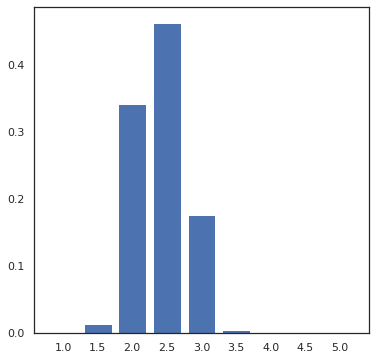

In [104]:
plt.bar(str_scores, predictions[1])

In [105]:
true_labels = np.empty(0)
for k, v in test_data.enumerate():
  true_labels = np.concatenate((true_labels, v[1].numpy()))

true_labels.shape

u, c = np.unique(true_labels, return_counts = True)
pd.Series(c, index = u)

1.5      3
2.0     69
2.5    167
3.0    210
3.5    190
4.0    108
4.5     26
5.0      9
dtype: int64

In [106]:
true_test_labels = create_test_ground_truth(test_data)
sorted(true_test_labels.items(), key=lambda pair: pair[0])

(782,)


[(1.0, 2),
 (1.5, 2),
 (2.0, 62),
 (2.5, 141),
 (3.0, 242),
 (3.5, 193),
 (4.0, 111),
 (4.5, 27),
 (5.0, 2)]

In [107]:
scores = [s/2 for s in range(2, 11)]
scores

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [108]:
np.array(scores)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [109]:
prediction_labels = [scores[np.argmax(p)]for p in predictions]
print(len(prediction_labels))
print(Counter(prediction_labels))


782
Counter({2.5: 782})


In [110]:
true_test_labels

Counter({3.5: 193,
         3.0: 242,
         2.5: 141,
         4.0: 111,
         4.5: 27,
         2.0: 62,
         5.0: 2,
         1.0: 2,
         1.5: 2})

In [127]:
labels = np.array([str(t) for t in true_labels])
predictions_labels = np.array([str(p) for p in prediction_labels])

In [128]:
Counter(labels)

Counter({'3.5': 1,
         '3.0': 1,
         '2.5': 1,
         '4.0': 1,
         '4.5': 1,
         '2.0': 1,
         '5.0': 1,
         '1.0': 1,
         '1.5': 1})

In [119]:
labels_ranks = np.unique(labels)
prediction_ranks = np.unique(predictions)

print(labels_ranks)
print(prediction_ranks)

['1.5' '2.0' '2.5' '3.0' '3.5' '4.0' '4.5' '5.0']
[1.6795582e-06 1.8646933e-06 1.8667606e-06 ... 4.7797555e-01 4.7946554e-01
 4.8015735e-01]


In [120]:
scores = [str(s) for s in scores]
scores

['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

In [ ]:
# # print accuracy for test
# y_test_pred_tf = model.predict(x=X_test_std)

# # set predicted label based on highest probability
# y_test_maxpred_tf =  np.argmax(y_test_pred_tf, axis=1)

# print('Test, misclassified examples: %d' % (y_test != y_test_maxpred_tf).sum())
# error_test_tf = (y_test != y_test_maxpred_tf).sum()/len(y_test_maxpred_tf)
# print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

# # plot confusion matrix
# conf_matrix = tf.math.confusion_matrix(
#     y_test,
#     y_test_maxpred_tf,
#     num_classes=None,
#     weights=None,
#     dtype=tf.dtypes.int32,
#     name=None
# )

# conf_matrix

# confusion_matrix_plot(conf_matrix.numpy())

In [193]:
predictions_labels

array(['2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5', '2.5',
       '2.5', '2.5',

In [192]:
cm = confusion_matrix(labels, predictions_labels)
cm

ValueError: ignored

In [126]:
true_test_labels

Counter({3.5: 193,
         3.0: 242,
         2.5: 141,
         4.0: 111,
         4.5: 27,
         2.0: 62,
         5.0: 2,
         1.0: 2,
         1.5: 2})

In [131]:
results_df = pd.DataFrame({"true":true_labels, "predictions":prediction_labels})
results_df.head()

,true,predictions
0,4.0,2.5
1,3.0,2.5
2,3.0,2.5
3,4.0,2.5
4,3.0,2.5


In [132]:
results_df['true'].value_counts()

3.0    210
3.5    190
2.5    167
4.0    108
2.0     69
4.5     26
5.0      9
1.5      3
Name: true, dtype: int64

In [133]:
results_df['predictions'].value_counts()

2.5    782
Name: predictions, dtype: int64

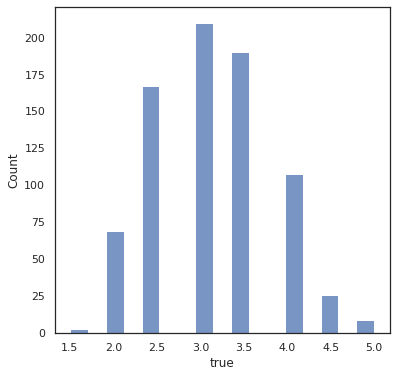

In [134]:
# test lables
sns.histplot(results_df, x = 'true')

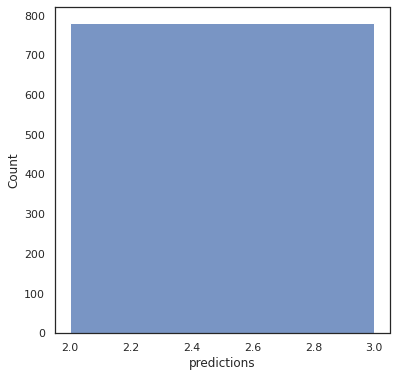

In [135]:
sns.histplot(results_df, x = 'predictions')

In [136]:
# weird error getting empty row/column in confusion matrix
df_cm = pd.DataFrame(cm, columns = labels_ranks, index = labels_ranks)

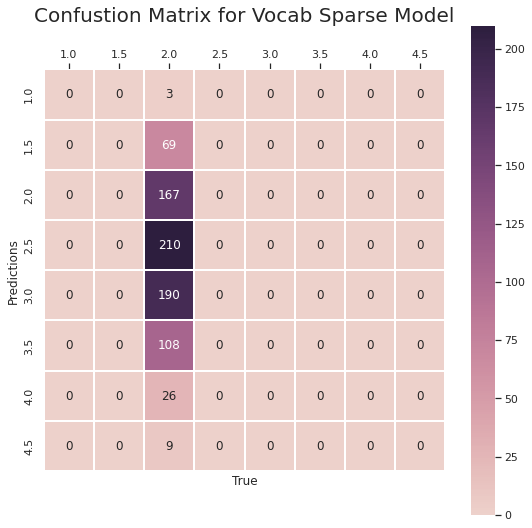

In [166]:
cm_map = cm_heatmap(df_cm, "Vocab Sparse Model")

cm_map.figure.savefig("sparse.png", dpi = 600)

All scores are weighted down and lower than expected, likely dragging accuracy 
down. 

### Precision - classifiers exactness

In [138]:
# True positives / True positives + false positives
results_df['positives'] = results_df['true'] == results_df['predictions']


In [157]:
# MSE
np.mean(np.square(results_df['true'] - results_df['predictions']))

0.8516624040920716

In [139]:
# Model metrics
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis = 0) - true_pos
false_neg = np.sum(cm, axis = 1) - true_pos

precision = np.sum(true_pos / (true_pos + false_pos))
recall = np.sum(true_pos / (true_pos + false_neg))

print("precision: ", precision)
print("recall: ", recall)

model_metrics = pd.DataFrame({"rank": labels_ranks, "true_pos":true_pos, "false_pos":false_pos, "false_neg":false_neg})
model_metrics['precision'] = model_metrics['true_pos']/(model_metrics['true_pos']+model_metrics['false_pos'])
model_metrics['recall'] = model_metrics['true_pos']/(model_metrics['true_pos']+model_metrics['false_neg'])
model_metrics

precision:  nan
recall:  1.0


,rank,true_pos,false_pos,false_neg,precision,recall
0,1.5,0,0,3,NaN,0.0
1,2.0,0,0,69,NaN,0.0
2,2.5,167,615,0,0.213555,1.0
3,3.0,0,0,210,NaN,0.0
4,3.5,0,0,190,NaN,0.0
5,4.0,0,0,108,NaN,0.0
6,4.5,0,0,26,NaN,0.0
7,5.0,0,0,9,NaN,0.0


Kappa (Cohen's Kappa) classification accuracy normalized by the imbalance of the classes in the data

ROC curves: Precision, recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance of thresholds of these values

Models: 
- 1
  - Optimizer: Adadelta
  - Loss: SparseCategoricalCrossentropy
  - Accuracy: 14.71%
- 2
  - Optimizer: SGD
  - Loss: SparseCategoricalCrossentropy
  - Accuracy: 39.51%

# SVM via sklearn

Works with relatively good success

In [158]:
train.dtypes

run_SVM_model = True

if run_SVM_model == True: 
  train['vocabulary'] = train['vocabulary'].astype("string")

  X = train['full_text']
  y = train['vocabulary']

  vectorizer = CountVectorizer(stop_words='english')
  X_vec = vectorizer.fit_transform(X)
  X_vec = X_vec.todense()
  X_vec

  tfidf = TfidfTransformer() # by default applies "l2" normalization
  X_tfidf = tfidf.fit_transform(X_vec)
  X_tfidf = X_tfidf.todense()
  X_tfidf

  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                      test_size = 0.3, 
                                                      random_state = 0)

  classifier = SVC(kernel='sigmoid')
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_test)

  confusion_matrix(y_test, y_pred)

In [160]:
  cm_svm = confusion_matrix(y_test, y_pred)

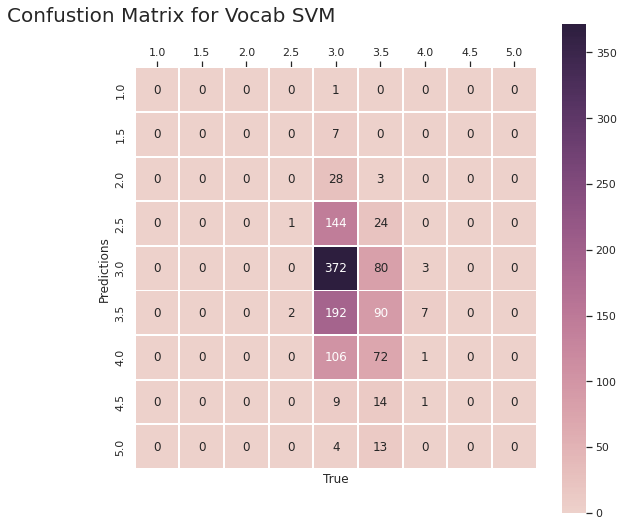

In [161]:
cm_heatmap(cm_svm, "Vocab SVM")